# Kickstarter - data engineering & analysis

- Write scrapy tool for more text (strengths & weaknesses) - need to deal with Javascript through json / selenium
- Consider LDA

### Libraries

In [0]:
from fastai import *
from fastai.text import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#path = "/content/gdrive/My Drive/Personal_projects/Kickstarter/"

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Personal_projects/Kickstarter/'
dest= Path(base_dir + "models/")

try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
File Already Exists


In [4]:
!pip install langdetect
!pip install names_dataset
!pip install namesparser

     |████████████████████████████████| 1.0MB 2.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=02f2054353dfadb3613152f71d00b6bc372a53cf221cfbb8e114e80febda3482
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 1.4MB 2.9MB/s 
  Created wheel for namesparser: filename=namesparser-1.0.0-cp36-none-any.whl size=2891 sha256=24c0c5f95aac085d2e8e9d333f1aa2bd1a6ed9f2744047d2fbf8b9274f96a46a
  Stored in directory: /root/.cache/pip/wheels/b4/8d/38/59eb785c722f8eecd5a590851a1ee70d9551d9ccb4ef880511
Successfully built namesparser


In [5]:
# Import useful libraries and change settings

# General
import numpy as np
import pandas as pd
import re
import math
import IPython
import sys
import pdb
from random import random
from langdetect import detect
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Scraping
import requests
from bs4 import BeautifulSoup

# General ML functions
import scipy.stats
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# NLP
from textblob import TextBlob
import spacy
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
from names_dataset import NameDataset
import nameparser

# Settings 
import warnings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Functions

In [0]:
def sentiment_func(x):
    sentiment = TextBlob(x['blurb'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x


def detect_language(text):
    try:
        return detect(text)
    except:
        return "Language Not Detected"

    
def filter_ks(data):
    print("Raw dataset: ", data.shape)
    data_unique = data[~data.duplicated(subset=['id'])]
    print("Unique dataset: ", data_unique.shape)
    data_final = data_unique[data_unique.state != 'live']
    print("Unique and live dataset: ", data_final.shape)
    return data_final


def process_ks(data):
    origin_date = pd.Timestamp('01-01-1970')
    data['deadline_datetime'] = origin_date + pd.TimedeltaIndex(round(data.deadline/(60*60*24)), unit='D')
    data['created_at_datetime'] = origin_date + pd.TimedeltaIndex(round(data.created_at/(60*60*24)), unit='D')
    data['launched_by_datetime'] = origin_date + pd.TimedeltaIndex(round(data.launched_at/(60*60*24)), unit='D')
    data['funding_window'] = (data.deadline_datetime - data.launched_by_datetime)/pd.Timedelta(days=1)
    data['creation_window'] = (data.launched_by_datetime - data.created_at_datetime)/pd.Timedelta(days=1)
    data['total_window'] = (data.deadline_datetime - data.created_at_datetime)/pd.Timedelta(days=1)
    data['launched_by_year'] = data.launched_by_datetime.map(lambda x: x.year)
    data['launched_by_month'] = data.launched_by_datetime.map(lambda x: x.month)
    data['launched_by_day'] = data.launched_by_datetime.map(lambda x: x.day)
    data.loc[data.state == 'successful','successful'] = True
    data.loc[data.state != 'successful','successful'] = False
    data['blurb_len'] = data.blurb.str.len()
    data['creator_name'] = data.creator.str.split(',').str[1].str.split(':').str[1].str.strip('""')
    data['creator_id'] = data.creator.str.split(',').str[0].str.split(':').str[1].astype(int)
    data['subcategory'] = data.category.str.split(',').str[1].str.split(':').str[1].str.strip('""')
    data['main_category'] = data.category.str.split(',').str[2].str.split(':').str[1].str.strip('""').str.split('/').str[0]
    data['project_url'] =data.urls.str.split('"').str[5]
    data['town'] = data.location.str.split(',').str[1].str.split(':').str[1].str.strip('""')
    data['county'] = data.location.str.split(',').str[9].str.split(':').str[1].str.strip('""')
    data.blurb.fillna('Unknown',inplace=True)
    data['goal_usd'] = data.goal * data.fx_rate
    data['funding_rate'] = data.goal_usd / data.funding_window
    
    return data


def creator_type(org_entity_field, name_field):
    if (org_entity_field != '[]' and name_field == False):
        return 'Organisation'
    else:
        return 'Individual'

## Load data

In [0]:
#path = r'kickstarter_data_2019_12_12'
#all_files = glob.glob(path + "/*.csv")

#li = []
#for filename in all_files:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    li.append(df)

#df_2019 = pd.concat(li, axis=0, ignore_index=True)

In [0]:
#path = r'kickstarter_data_2018_11_15'
#all_files = glob.glob(path + "/*.csv")

#li = []
#for filename in all_files:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    li.append(df)

#df_2018 = pd.concat(li, axis=0, ignore_index=True)

In [0]:
df_2019 = pd.read_csv(base_dir + "raw_kickstarter_2019.csv")

In [10]:
df_2019.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [11]:
test = df_2019.creator.str.split(',').str[0].str.split(':').str[1].astype(int)
#test = df_2019.creator.str.split(',').str[0].str.split(':').str[1].str.strip('""')
test.dtypes

dtype('int64')

In [12]:
#Check size
print("2019 datafile: ", df_2019.memory_usage(index=True).sum()/10**6, "MB")
#print("2018 datafile: ", df_2018.memory_usage(index=True).sum()/10**6, "MB")

2019 datafile:  58.050328 MB


In [0]:
# Scrape data

#URL = kickstarter_2019.project_url[1]
#response = requests.get(URL)
#extract = BeautifulSoup(response.text, 'html.parser')
#text = BeautifulSoup(response.text, 'lxml')
#extract = text.find('div',attrs={'id':'story'})
#extract = text.find('div',attrs={'class':'rte___content'})
#extract2 = extract.find('div')
#extract3 = extract2.find('p')

#for row in extract.findAll('div', attrs = {'class':'quote'}): 
#    quote = {} 
#    quote['theme'] = row.h5.text 

#extract.contents
#print(text.prettify())
#print(extract.prettify())

## Data cleansing 2019

In [14]:
kickstarter_2019 = filter_ks(df_2019)
print("-----")
#kickstarter_2018 = filter_ks(df_2018)

# Engineer dataset
kickstarter_2019 = process_ks(kickstarter_2019)
#kickstarter_2018 = process_ks(kickstarter_2018)

Raw dataset:  (215800, 38)
Unique dataset:  (188385, 38)
Unique and live dataset:  (185050, 38)
-----


In [15]:
# Remove all duplicates from 2019 analysis

kickstarter_2019['duplicate'] = kickstarter_2019.duplicated('blurb', keep=False)
duplicates = kickstarter_2019[kickstarter_2019.duplicate == True].sort_values(by=['blurb','launched_by_datetime'])
print(duplicates.shape)
kickstarter_2019 = kickstarter_2019[kickstarter_2019.duplicate == False]

(2792, 59)


In [0]:
# Remove all duplicates from 2018 analysis

#kickstarter_2018['duplicate'] = kickstarter_2018.duplicated('blurb', keep=False)
#duplicates = kickstarter_2018[kickstarter_2018.duplicate == True].sort_values(by=['blurb','launched_by_datetime'])
#print(duplicates.shape)
#kickstarter_2018 = kickstarter_2018[kickstarter_2018.duplicate == False]

In [17]:
# Filter 2019 kickstarter data for English descroptions

print(kickstarter_2019.shape)
%time kickstarter_2019["language_est"] = kickstarter_2019.blurb.apply(detect_language)
kickstarter_2019 = kickstarter_2019[kickstarter_2019.language_est == 'en']
print(kickstarter_2019.shape)

(182258, 59)
CPU times: user 13min 14s, sys: 9.39 s, total: 13min 24s
Wall time: 13min 24s
(175200, 60)


In [0]:
# Filter 2018 kickstarter data for English descroptions

#print(kickstarter_2018.shape)
#%time kickstarter_2018["language_est"] = kickstarter_2018.blurb.apply(detect_language)
#kickstarter_2018 = kickstarter_2018[kickstarter_2018.language_est == 'en']
#print(kickstarter_2018.shape)

### Feature engineering

In [19]:
# Add % target
kickstarter_2019['perc_target'] = kickstarter_2019['usd_pledged']/kickstarter_2019['goal']

# Add objectivity and polarity
%time kickstarter_2019 = kickstarter_2019.apply(sentiment_func, axis=1)

CPU times: user 9min 15s, sys: 1.87 s, total: 9min 17s
Wall time: 9min 17s


In [20]:
# Add creator type
m = NameDataset()
kickstarter_2019['first_name'] = kickstarter_2019.creator_name.str.split(' ').apply(lambda x: x[0]).str.lower()
kickstarter_2019['creator_individual_name_dataset'] = kickstarter_2019.first_name.apply(lambda x: m.search_first_name(x))

nlp = spacy.load("en")
%time kickstarter_2019['creator_person_entity'] = kickstarter_2019.apply(lambda row: [token for token in nlp(row.creator_name) if token.ent_type_ == 'PERSON'], axis=1)
%time kickstarter_2019['creator_org_entity'] = kickstarter_2019.apply(lambda row: [token for token in nlp(row.creator_name) if token.ent_type_ == 'ORG'], axis=1)

kickstarter_2019['creator_type'] = kickstarter_2019.apply(lambda x: creator_type(x['creator_org_entity'],x['creator_individual_name_dataset']),axis=1)

CPU times: user 23min 32s, sys: 3.34 s, total: 23min 35s
Wall time: 23min 35s
CPU times: user 23min 25s, sys: 2.46 s, total: 23min 28s
Wall time: 23min 28s


## Exploratory Data Analysis

### 2019 vs 2018 analysis

In [0]:
#df_summary_2019 = kickstarter_2019[['launched_by_year','successful']]
df_summary_2019 = kickstarter_2019[['launched_by_year','successful']].groupby(['launched_by_year']).agg(['count','mean']).reset_index()
df_summary_2019.columns = ['launched_by_year','project_count','project_success_rate']

In [0]:
#df_summary_2018 = kickstarter_2018[['launched_by_year','successful']].groupby(['launched_by_year']).agg(['count','mean']).reset_index()
#df_summary_2018.columns = ['launched_by_year','project_count','project_success_rate']

In [0]:
#comparison_18_19 = df_summary_2019.merge(df_summary_2018, how='left', on='launched_by_year')
#comparison_18_19.columns = ['launched_by_year', 'project_count_2019', 'success_rate_2019','project_count_2018', 'success_rate_2018']
#ax = sns.lineplot(x="launched_by_year", y="success_rate_2019", data=comparison_18_19)
#ax = sns.lineplot(x="launched_by_year", y="success_rate_2018", data=comparison_18_19)

In [0]:
#ax = sns.lineplot(x="launched_by_year", y="project_count_2019", data=comparison_18_19)
#ax = sns.lineplot(x="launched_by_year", y="project_count_2018", data=comparison_18_19)

In [0]:
# Merge on ids
#id_2019 = kickstarter_2019[['id','launched_by_year','successful']].rename(columns = {'launched_by_year':'year_19','successful':'success_rate_19'})
#id_2018 = kickstarter_2018[['id','launched_by_year','successful']].rename(columns = {'launched_by_year':'year_18','successful':'success_rate_18'})

#comparison_18_19 = id_2018.merge(id_2019, how='left', on='id').drop(['id','year_19'],axis=1)
#summary_18_19 = comparison_18_19.groupby(['year_18']).agg(['count']).reset_index()
#summary_18_19.columns = ['launched_by_year','2018_records','2019_records']
#ax = sns.lineplot(x="launched_by_year", y="2019_records", data=summary_18_19)
#ax = sns.lineplot(x="launched_by_year", y="2018_records", data=summary_18_19)

In [0]:
size_bins = np.array([0,5000,10000,30000,100000,500000,1000000,100000000,10000000000])
categories = ['0-5k','5-10k','10-30k','30-100k','100-500k','500k-1m','1-10m','10m+']
size_distn = kickstarter_2019['bucket'] = pd.cut(kickstarter_2019.usd_pledged, size_bins)
size_distn = kickstarter_2019[['bucket','usd_pledged']].groupby(['bucket']).agg(['count','sum'])
size_distn.reset_index(inplace=True)
size_distn.columns = ['bucket_range','count','usd_sum']
size_distn['category'] = categories

In [27]:
size_distn

,bucket_range,count,usd_sum,category
0,"(0, 5000]",107060,1.268939e+08,0-5k
1,"(5000, 10000]",19819,1.362197e+08,5-10k
2,"(10000, 30000]",20726,3.440769e+08,10-30k
3,"(30000, 100000]",8308,4.209359e+08,30-100k
4,"(100000, 500000]",2832,5.472451e+08,100-500k
5,"(500000, 1000000]",324,2.139405e+08,500k-1m
6,"(1000000, 100000000]",195,3.923049e+08,1-10m
7,"(100000000, 10000000000]",0,0.000000e+00,10m+


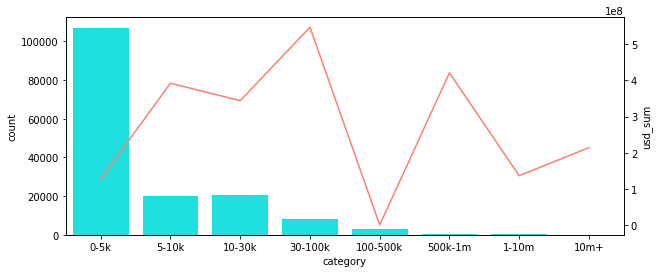

In [28]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
sns.lineplot(x='category', y='usd_sum', data=size_distn, color = 'salmon', ax=ax2)
sns.barplot(x='category', y='count', data= size_distn, color='aqua', ax=ax1)
plt.show()
sns.set()

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

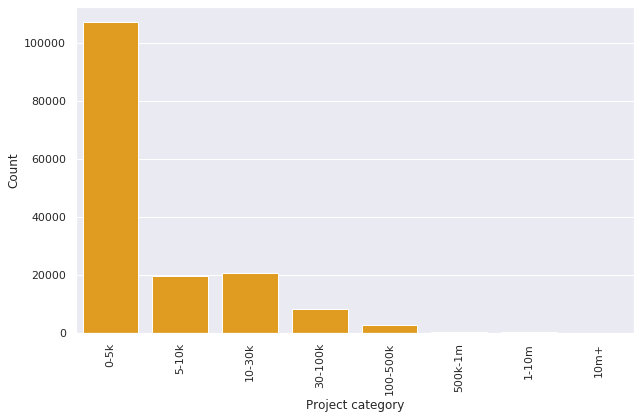

In [29]:
fig, ax = plt.subplots()
ax = sns.barplot(x="category", y="count", data=size_distn, color = 'orange')
ax.set(xlabel='Project category', ylabel='Count')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

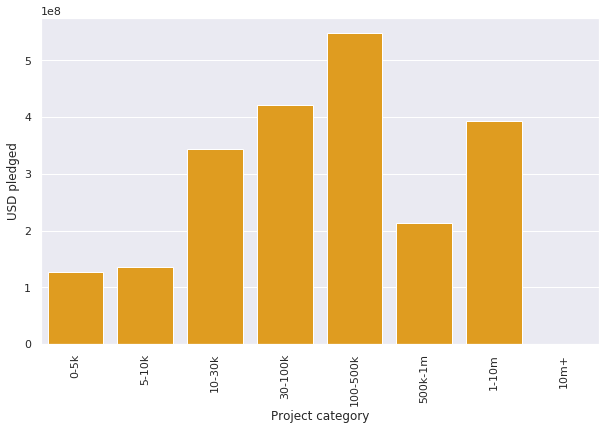

In [30]:
fig, ax = plt.subplots()
ax = sns.barplot(x="category", y="usd_sum", data=size_distn, color = 'orange')
ax.set(xlabel='Project category', ylabel='USD pledged')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

### Project category analysis

In [0]:
# Annual analysis
summary = kickstarter_2019[['launched_by_year','goal','pledged','successful']]
summary.groupby(['launched_by_year']).agg(['count','mean','sum'])
summary.columns = summary.columns.map('_'.join).str.strip('|')

In [0]:
# Category analysis
summary = kickstarter_2019[['main_category','goal','usd_pledged','successful']].groupby(['main_category']).agg(['count','mean','sum','max'])
summary.columns = summary.columns.map('_'.join).str.strip('|')
summary.sort_values(by=['goal_count'], ascending=False, inplace=True)
summary.reset_index(inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

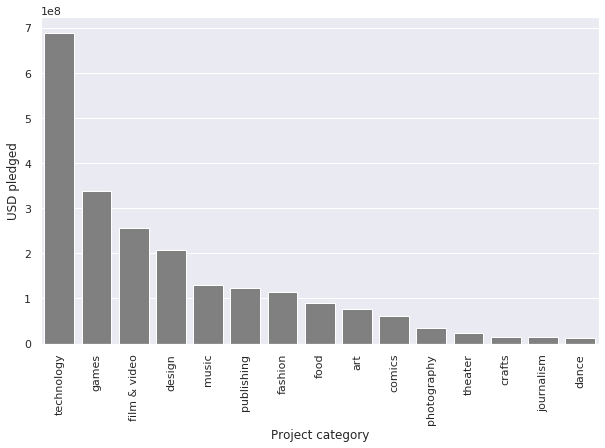

In [33]:
summary.sort_values(by=['usd_pledged_sum'], ascending=False, inplace=True)
fig, ax = plt.subplots()
ax = sns.barplot(x="main_category", y="usd_pledged_sum", data=summary, color = 'grey')
ax.set(xlabel='Project category', ylabel='USD pledged')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

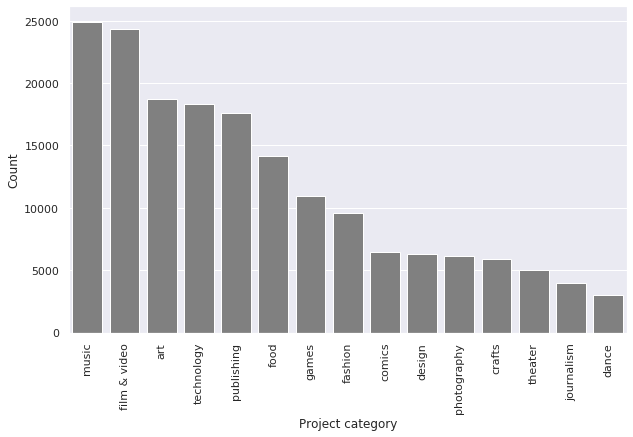

In [34]:
summary.sort_values(by=['goal_count'], ascending=False, inplace=True)
fig, ax = plt.subplots()
ax = sns.barplot(x="main_category", y="goal_count", data=summary, color = 'grey')
ax.set(xlabel='Project category', ylabel='Count')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

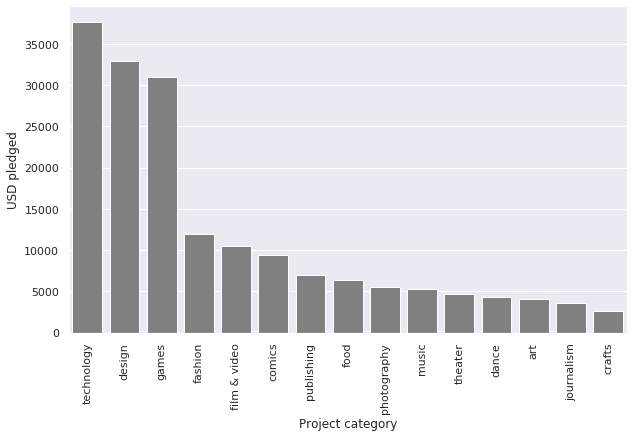

In [35]:
summary.sort_values(by=['usd_pledged_mean'], ascending=False, inplace=True)
fig, ax = plt.subplots()
ax = sns.barplot(x="main_category", y="usd_pledged_mean", data=summary, color = 'grey')
ax.set(xlabel='Project category', ylabel='USD pledged')
fig.set_size_inches(10,6)
plt.xticks(rotation=90)

No handles with labels found to put in legend.


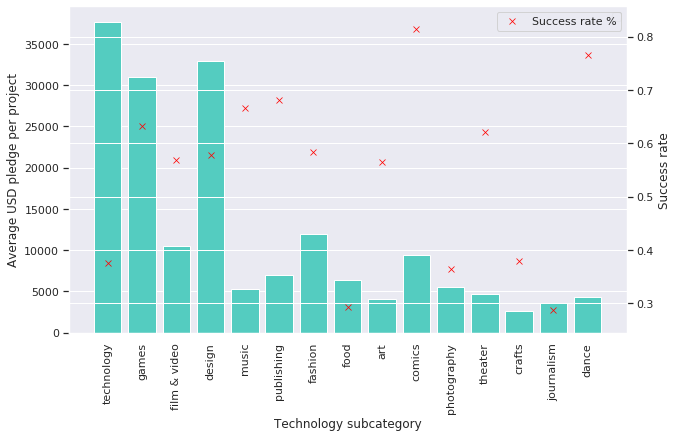

In [36]:
summary.sort_values(by=['usd_pledged_sum'], ascending=False, inplace=True)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

chart = sns.barplot(x="main_category", y="usd_pledged_mean", data=summary, color = 'turquoise', ax=ax1)
sns.scatterplot(x="main_category", y="successful_mean", data=summary, color = 'red', ax=ax2, marker = 'x', label = 'Success rate %',)

ax1.set(xlabel='Technology subcategory', ylabel='Average USD pledge per project')
ax2.set(ylabel='Success rate')
fig.set_size_inches(10,6)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
ax1.legend(loc=0)
plt.show()

### Technology project analysis

In [0]:
# Subcategory analysis
summary_sub_cat = kickstarter_2019[kickstarter_2019.main_category == 'technology'][['main_category','subcategory','goal','pledged','successful']].groupby(['main_category','subcategory']).agg(['count','mean','sum'])
summary_sub_cat.columns = summary_sub_cat.columns.map('_'.join).str.strip('|')
summary_sub_cat.reset_index(inplace=True)

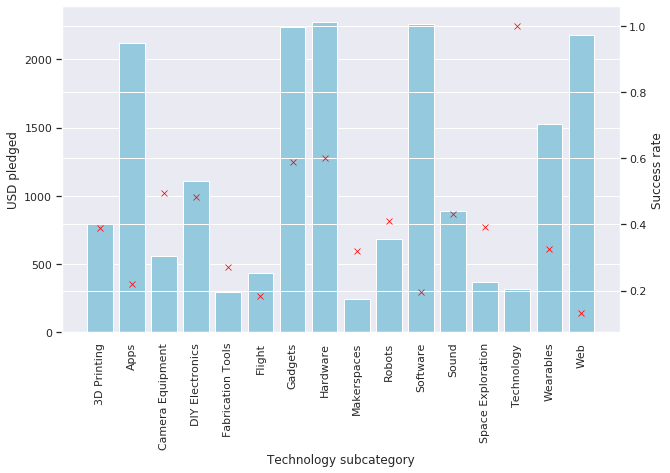

In [42]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

chart = sns.barplot(x="subcategory", y="goal_count", data=summary_sub_cat, color = 'skyblue', ax=ax1)
sns.scatterplot(x="subcategory", y="successful_mean", data=summary_sub_cat, color = 'red', ax=ax2, marker = 'x')

ax1.set(xlabel='Technology subcategory', ylabel='USD pledged')
ax2.set(ylabel='Success rate')
fig.set_size_inches(10,6)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

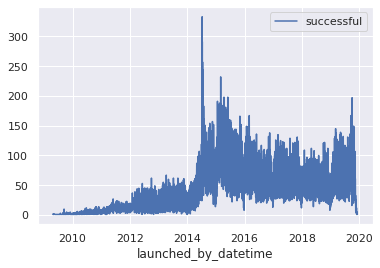

In [43]:
df_time = kickstarter_2019[['launched_by_datetime','successful']].groupby(['launched_by_datetime']).count()
sns.lineplot(data=df_time)
fig.set_size_inches(20,12)

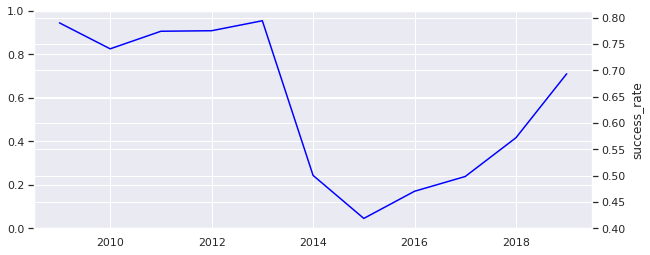

In [44]:
df_time = kickstarter_2019[['launched_by_year','successful']].groupby(['launched_by_year']).agg(['count','mean'])
df_time.reset_index(inplace=True)
df_time.columns = ['launched_by_year','project_count','success_rate']

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

#sns.barplot(x='launched_by_year', y='project_count', data= df_time, color='salmon', ax=ax1)
sns.lineplot(x='launched_by_year', y='success_rate', data= df_time, color='blue', ax=ax2)

plt.show()
sns.set()

### Top projects

In [45]:
pd.set_option('display.max_colwidth', -1)
kickstarter_2019.sort_values('usd_pledged', ascending=False).head(5)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,deadline_datetime,created_at_datetime,launched_by_datetime,funding_window,creation_window,total_window,launched_by_year,launched_by_month,launched_by_day,successful,blurb_len,creator_name,creator_id,subcategory,main_category,project_url,town,county,goal_usd,funding_rate,duplicate,language_est,perc_target,polarity,subjectivity,first_name,creator_individual_name_dataset,creator_person_entity,creator_org_entity,creator_type,bucket
9769,27168,A full-featured tripod in a truly portable form.,"{""id"":28,""name"":""Product Design"",""slug"":""design/product design"",""position"":5,""parent_id"":7,""color"":2577151,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/design/product%20design""}}}",12143435,US,the United States,1556224168,"{""id"":97103764,""name"":""Peak Design"",""slug"":""peak-design"",""is_registered"":null,""chosen_currency"":null,""is_superbacker"":null,""avatar"":{""thumb"":""https://ksr-ugc.imgix.net/assets/006/023/679/e2d8ec5dea004fd1f2bf17c7bb62d525_original.png?ixlib=rb-2.1.0&w=40&h=40&fit=crop&v=1510175320&auto=format&frame=1&q=92&s=81d408e16ce9d63f8b29e0da0de6fe21"",""small"":""https://ksr-ugc.imgix.net/assets/006/023/679/e2d8ec5dea004fd1f2bf17c7bb62d525_original.png?ixlib=rb-2.1.0&w=160&h=160&fit=crop&v=1510175320&auto=format&frame=1&q=92&s=e4c92f31aba1875f267533c5d25ae730"",""medium"":""https://ksr-ugc.imgix.net/assets/006/023/679/e2d8ec5dea004fd1f2bf17c7bb62d525_original.png?ixlib=rb-2.1.0&w=160&h=160&fit=crop&v=1510175320&auto=format&frame=1&q=92&s=e4c92f31aba1875f267533c5d25ae730""},""urls"":{""web"":{""user"":""https://www.kickstarter.com/profile/peak-design""},""api"":{""user"":""https://api.kickstarter.com/v1/users/97103764?signature=1576211455.6845323629ac5084c2963f95f536cd009f105332""}}}",USD,$,True,USD,1563494400,False,NaN,1.0,500000.0,1289129165,NaN,False,NaN,1558447202,"{""id"":2487956,""name"":""San Francisco"",""slug"":""san-francisco-ca"",""short_name"":""San Francisco, CA"",""displayable_name"":""San Francisco, CA"",""localized_name"":""San Francisco"",""country"":""US"",""state"":""CA"",""type"":""Town"",""is_root"":false,""expanded_country"":""United States"",""urls"":{""web"":{""discover"":""https://www.kickstarter.com/discover/places/san-francisco-ca"",""location"":""https://www.kickstarter.com/locations/san-francisco-ca""},""api"":{""nearby_projects"":""https://api.kickstarter.com/v1/discover?signature=1576191125.8bc584e67f5b294cd2cc013d15f1dbf26d89685e&woe_id=2487956""}}}",Travel Tripod by Peak Design,NaN,"{""key"":""assets/025/855/992/1c00ede28eba30818fd7f52d1e5e0bad_original.jpg"",""full"":""https://ksr-ugc.imgix.net/assets/025/855/992/1c00ede28eba30818fd7f52d1e5e0bad_original.jpg?ixlib=rb-2.1.0&crop=faces&w=560&h=315&fit=crop&v=1563493272&auto=format&frame=1&q=92&s=47dcec7503d0bcfd20ea2b523cf17a17"",""ed"":""https://ksr-ugc.imgix.net/assets/025/855/992/1c00ede28eba30818fd7f52d1e5e0bad_original.jpg?ixlib=rb-2.1.0&crop=faces&w=352&h=198&fit=crop&v=1563493272&auto=format&frame=1&q=92&s=231e9ab9513994b8214bc201fa2b9a63"",""med"":""https://ksr-ugc.imgix.net/assets/025/855/992/1c00ede28eba30818fd7f52d1e5e0bad_original.jpg?ixlib=rb-2.1.0&crop=faces&w=272&h=153&fit=crop&v=1563493272&auto=format&frame=1&q=92&s=e1bd038ff18162a3dbdf0e1bc52299b9"",""little"":""https://ksr-ugc.imgix.net/assets/025/855/992/1c00ede28eba30818fd7f52d1e5e0bad_original.jpg?ixlib=rb-2.1.0&crop=faces&w=208&h=117&fit=crop&v=1563493272&auto=format&frame=1&q=92&s=928f78277e21573f33431a4fbd37771e"",""small"":""https://ksr-ugc.imgix.net/assets/025/855/992/1c00ede28eba30818fd7f52d

## Output

In [0]:
# Copy output to file
kickstarter_2019.to_csv(base_dir + "kickstarter.csv", index=False)

In [0]:
kickstarter_2019 = pd.read_csv(base_dir + "kickstarter.csv")

In [0]:
# Save consolidated set of columns
kickstarter_model = kickstarter_2019[['country', 'town', 'county',
                                        'main_category', 'subcategory',
                                        'funding_window','creation_window','total_window', 
                                        'launched_by_year', 'launched_by_month', 'launched_by_day',
                                        'currency', 'static_usd_rate', 'goal', 'pledged', 'usd_type',
                                        'blurb', 'slug', 'blurb_len', 'polarity', 'subjectivity',
                                        'creator_type','creator_id', 
                                        'staff_pick','disable_communication','is_starrable',
                                        'usd_pledged','goal_usd', 'funding_rate', #'converted_pledged_amount',
                                        'successful', 'perc_target'
                                     ]]
kickstarter_model.to_csv(base_dir + "kickstarter_model.csv", index=False)

In [49]:
kickstarter_model.describe()

,funding_window,creation_window,total_window,launched_by_year,launched_by_month,launched_by_day,static_usd_rate,goal,pledged,blurb_len,polarity,subjectivity,creator_id,usd_pledged,goal_usd,funding_rate,perc_target
count,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000,1.752000e+05,1.752000e+05,175200.000000,175200.000000,175200.000000,1.752000e+05,1.752000e+05,1.752000e+05,1.752000e+05,175200.000000
mean,32.798042,48.383613,81.181655,2015.797460,6.437123,15.173430,1.018426,5.132430e+04,1.790260e+04,111.364949,0.149797,0.395743,1.073497e+09,1.245215e+04,4.257934e+04,1.398436e+03,5.287172
std,11.892722,135.115653,135.906784,2.139811,3.283908,8.818716,0.209969,1.259894e+06,4.954591e+05,27.232222,0.255347,0.291377,6.201611e+08,9.465889e+04,1.132555e+06,5.977765e+04,522.031974
min,1.000000,0.000000,1.000000,2009.000000,1.000000,1.000000,0.008771,1.000000e+00,0.000000e+00,4.000000,-1.000000,0.000000,3.000000e+00,0.000000e+00,5.188108e-01,1.097008e-02,0.000000
25%,30.000000,3.000000,33.000000,2014.000000,4.000000,8.000000,1.000000,1.500000e+03,8.800000e+01,99.000000,0.000000,0.133333,5.367520e+08,8.600000e+01,1.500000e+03,5.000000e+01,0.015714
50%,30.000000,11.000000,47.000000,2016.000000,6.000000,15.000000,1.000000,5.000000e+03,1.395000e+03,123.000000,0.100000,0.400000,1.072745e+09,1.402000e+03,5.000000e+03,1.612903e+02,1.003071
75%,35.000000,37.000000,73.000000,2018.000000,9.000000,23.000000,1.000000,1.500000e+04,6.363000e+03,132.000000,0.300000,0.600000,1.610519e+09,6.280000e+03,1.321770e+04,4.211063e+02,1.287549
max,97.000000,3303.000000,3333.000000,2019.000000,12.000000,31.000000,1.716408,1.000000e+08,1.469719e+08,151.000000,1.000000,1.000000,2.147483e+09,1.214344e+07,1.313810e+08,1.375000e+07,195650.146249
